# Confusion Matrix
## Adam Optimizer, Dropout 0.2, Batch Normalization, Data Augmentation, Xavier Initialization, Learning Rate Scheduler (Reduce Learning Rate on Plateau)

In [6]:
import os
import torch
import codecs
from torch import nn
import matplotlib.pyplot as plt
import seaborn as sns
import dill as pickle
from sklearn.metrics import confusion_matrix

from data_utils import TrafficSignsDataset
from torch.utils.data import DataLoader
from model_utils import TrafficSignsConvNet
from training_utils import load_checkpoint, validate

In [7]:
data_dir = 'data/gtsrb-german-traffic-sign/Train'
ckpt_path = 'models/adam_batchnorm_dataaug_xavier_lrscheduler_dropout0.2/best.pt'
num_classes = 5
batch_size = 64
use_batch_norm = True

In [8]:
# set device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'device: {device}')

# data file paths
filepaths = {}
for category in ['test']:
    with codecs.open(os.path.join(data_dir, f'{category}.txt'),
                     'r', encoding='utf-8') as f:
        filepaths[category] = list(map(str.strip, f.readlines()))


# datasets
datasets = {}
for category in ['test']:
    if os.path.exists(f'{data_dir}/{category}.pkl'):
        # load dataset from pickle file
        print(f'loading {category} dataset from pickle file..')
        with open(f'{data_dir}/{category}.pkl', 'rb') as f:
            datasets[category] = pickle.load(f)
    else:
        datasets[category] = TrafficSignsDataset(filepaths=filepaths[category])
        # dump
        print(f'writing {category} dataset to pickle file..')
        with open(f'{data_dir}/{category}.pkl', 'wb') as f:
            pickle.dump(datasets[category], f)

# data loader
test_loader = DataLoader(datasets['test'], batch_size=batch_size, shuffle=False)

# model
model = TrafficSignsConvNet(
    num_classes=num_classes,
    batch_norm=use_batch_norm
)

# transfer model to device
model = model.to(device)

# criterion
criterion = nn.CrossEntropyLoss()

# load checkpoint
print(f'loading checkpoint {ckpt_path}')
state = load_checkpoint(ckpt_path, model, device=device)

# predict

test_loss, test_acc, test_preds, test_labels = validate(model, test_loader, criterion, device, True)


# print results
print(f'test loss: {test_loss:0.4f}, test acc: {test_acc:0.2f} %')

device: cpu
loading test dataset from pickle file..
loading checkpoint models/adam_batchnorm_dataaug_xavier_lrscheduler_dropout0.2/best.pt
	(val) loss: 0.0393, acc: 99.50 %

test loss: 0.0393, test acc: 99.50 %


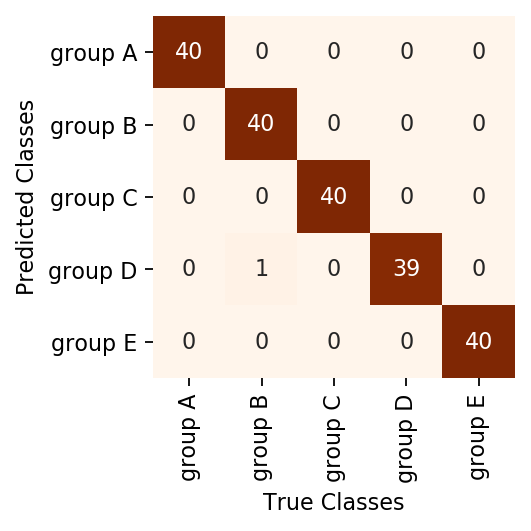

In [11]:
group_names = ['group A', 'group B', 'group C', 'group D', 'group E']
conf_mat = confusion_matrix(y_true=test_labels, y_pred=test_preds)
plt.figure(figsize=(3, 3), dpi=160)
# plot matrix
sns.heatmap(
    conf_mat,
    cmap=plt.cm.Oranges,
    square=True,  # shape of each cell is a square (arr need not be a square matrix)
    annot=True,  # annotate cells
    xticklabels=group_names,
    yticklabels=group_names,
    cbar=False
)

# set x and y labels
plt.xlabel('True Classes')
plt.ylabel('Predicted Classes')
plt.show()